# Assignement 3 : Reinforcement Learning with Function Approximation

Name : Fatine BOUJNOUNI


## 1 - On-Policy Reinforcement Learning with Parametric Policy

In [8]:
# Imports 
import numpy as np
import lqg1d
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D


In [9]:
#####################################################
# Define the environment and the policy
#####################################################
env = lqg1d.LQG1D(initial_state_type='random')

In [10]:
class GaussianPolicy:
    def __init__(self, sigma, theta):
        self.sigma = sigma
        self.theta = theta

    def draw_action(self, s):
        return np.random.normal(self.theta * s, self.sigma)   
    
    def grad_log_pi(self, a, s):
        self.mu = self.theta*s
        return ((a - self.mu)*s)/(self.sigma**2)
    
    def grad_log_pi_paths(self, paths, n, t):
        return self.grad_log_pi(paths[n]["actions"][t], paths[n]["states"][t])
    
    def grad_J(self, paths, discount, N, T):
        discounts = np.array([discount**t for t in range(T)])
        gradJ = sum(sum( self.grad_log_pi_paths(paths,n,t) * (np.dot(discounts[t:], paths[n]["rewards"][t:]))
                        for t in range(T)) for n in range(N))
        return gradJ / N


In [11]:
class ConstantStep(object):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt):
        return self.learning_rate * gt
    

class AdamStep(object):
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8, alpha=0.1):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.alpha = alpha
        self.m = 0
        self.v = 0
        self.t = 0

    def update(self, gt):
        self.t += 1
        self.m = self.beta1*self.m + (1-self.beta1)*gt
        self.v = self.beta2*self.v + (1-self.beta2) * (gt*gt)
        self.m_estimate = self.m / (1-self.beta1**self.t)
        self.v_estimate = self.v / (1-self.beta2**self.t)
        return (self.alpha*self.m_estimate) / (np.sqrt(self.v_estimate)+self.epsilon)




### REINFORCE

In [12]:
def REINFORCE(theta, sigma, T, N, n_itr, stepper, discount):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy function approximator
    using policy gradient.
    
    Parameters : 
    ==========
    theta : float, theta of the policy 
    sigma : float, sigma of the policy
    T : int, time horizon 
    N : int , Number of trajectories per iteration 
    n_iter : int , Number of policy parameters updates
    stepper : object , update stepper
    discount : float, discount factor 
    
    Returns the average of rewards and the updated thetas
    """
    thetas = []
    thetas_CI_min = []
    thetas_CI_max = []
    avg_return = []
    
    thetas.append(theta)
    
    for i in range(n_itr):
        # Initiate Gaussian Policy 
        policy = GaussianPolicy(sigma, theta)
        
        paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)
        
        # Compute the average returns 
        R = utils.estimate_performance(env, policy=policy, horizon=T, n_episodes=N, gamma=discount)
        avg_return.append(R)
        
        
        gradJ = policy.grad_J(paths, discount, N, T)
        
        
        # Confiance intervals 
        std = np.std(gradJ)
        gradJ_min = gradJ - 2 * (std/np.sqrt(N))
        gradJ_max = gradJ + 2 * (std/np.sqrt(N))
        
        thetas_CI_min.append(np.asscalar(theta + stepper.update(gradJ_min)))
        thetas_CI_max.append(np.asscalar(theta + stepper.update(gradJ_max)))
        
        # Update theta of the policy 
        theta += stepper.update(gradJ)
        thetas.append(np.asscalar(theta))
        
    return thetas, avg_return, thetas_CI_min, thetas_CI_max
        

In [13]:
#####################################################
# Experiments parameters
#####################################################
# We will collect N trajectories per iteration
N = 100
# Each trajectory will have at most T time steps
T = 100
# Number of policy parameters updates
n_itr = 100
# Set the discount factor for the problem
discount = 0.9
# Learning rate for the gradient update
learning_rate = 0.001
# theta*
theta_s = -0.6
# sigma 
sigma = 0.4

In [15]:
# Different learning rates 
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
thetas = {}
MC_returns = {}
for lr in learning_rates:
    policy = GaussianPolicy(0.4, 0)
    stepper = ConstantStep(lr)
    thetas[lr] , MC_returns[lr], _, _ = REINFORCE(0, sigma, T, N, n_itr, stepper, discount)

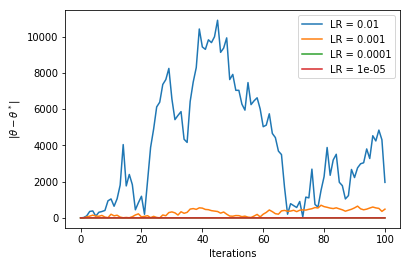

In [16]:
plt.figure()
for lr in learning_rates:
    theta_diff = [abs(theta - theta_s) for theta in thetas[lr]]
    plt.plot(theta_diff, label ="LR = {}".format(lr))
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

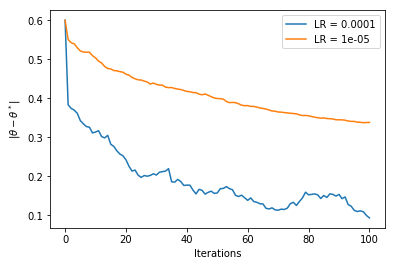

In [17]:
plt.figure()
for lr in learning_rates[2:]:
    theta_diff = [abs(theta - theta_s) for theta in thetas[lr]]
    plt.plot(theta_diff, label ="LR = {}".format(lr))
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

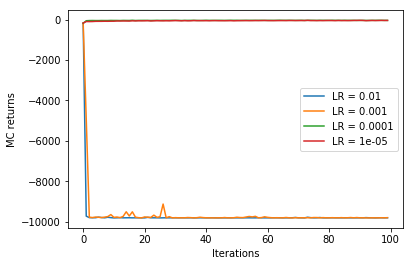

In [18]:
plt.figure()
for lr in learning_rates:
    plt.plot(MC_returns[lr], label ="LR = {}".format(lr))
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

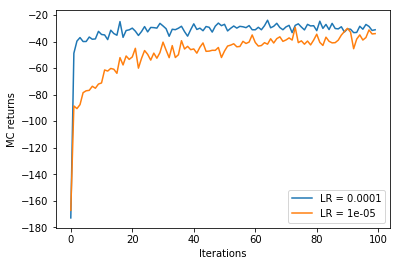

In [19]:
plt.figure()
for lr in learning_rates[2:]:
    plt.plot(MC_returns[lr], label ="LR = {}".format(lr))
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

The algorithm doesn't converge for the learning rate 0.01
It converges for the learning rate = 0.0001. The algorithm with the learning rate $10^{-5}$ needs more iterations to converge. 


We can say that if the learning rate is too small, the convergence is slow. And if it is too big, the convergence is not stable.  

In [20]:
# Different number of trajectories  
N_trajectories = [50, 100, 200, 300, 400]
learning_rate = 0.0001
thetas = {}
MC_returns = {}
for N in N_trajectories:
    policy = GaussianPolicy(0.4, 0)
    stepper = ConstantStep(learning_rate)
    thetas[N] , MC_returns[N], _, _ = REINFORCE(0, sigma, T, N, n_itr, stepper, discount)

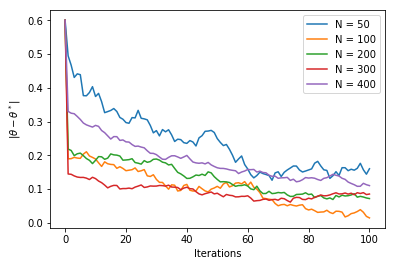

In [21]:
plt.figure()
for N in N_trajectories:
    theta_diff = [abs(theta - theta_s) for theta in thetas[N]]
    plt.plot(theta_diff, label ="N = {}".format(N))
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

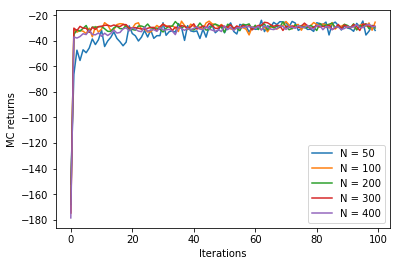

In [22]:
plt.figure()
for N in N_trajectories:
    plt.plot(MC_returns[N], label ="N = {}".format(N))
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

A big N leads to a better variance minimization. But a big N takes a higher time of computation. 

In [25]:
# Different number of trajectories  
T_steps = [50, 100, 200, 300, 400]
learning_rate = 0.0001
N = 100
thetas = {}
MC_returns = {}
for T in T_steps:
    policy = GaussianPolicy(0.4, 0)
    stepper = ConstantStep(learning_rate)
    thetas[T] , MC_returns[T], _, _ = REINFORCE(0, sigma, T, N, n_itr, stepper, discount)

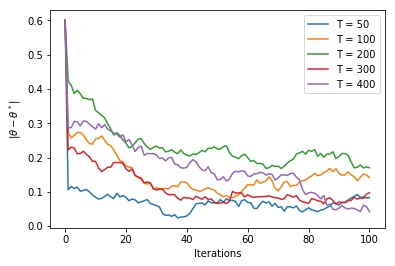

In [26]:
plt.figure()
for T in T_steps:
    theta_diff = [abs(theta - theta_s) for theta in thetas[T]]
    plt.plot(theta_diff, label ="T = {}".format(T))
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

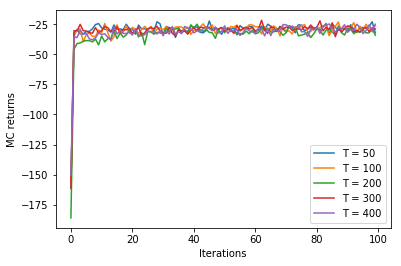

In [27]:
plt.figure()
for T in T_steps:
    plt.plot(MC_returns[T], label ="T = {}".format(T))
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

In [28]:
# Different sigmas 
sigmas = [0.3, 0.4, 0.5, 0.6, 0.7]
learning_rate = 0.0001
N = 100
T = 400
thetas = {}
MC_returns = {}
for sigma in sigmas:
    policy = GaussianPolicy(sigma, 0)
    stepper = ConstantStep(learning_rate)
    thetas[sigma] , MC_returns[sigma], _, _ = REINFORCE(0, sigma, T, N, n_itr, stepper, discount)

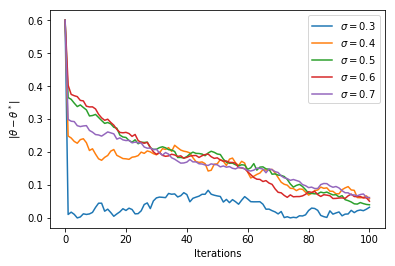

In [29]:
plt.figure()
for sigma in sigmas:
    theta_diff = [abs(theta - theta_s) for theta in thetas[sigma]]
    plt.plot(theta_diff, label =r"$\sigma = {}$".format(sigma))
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

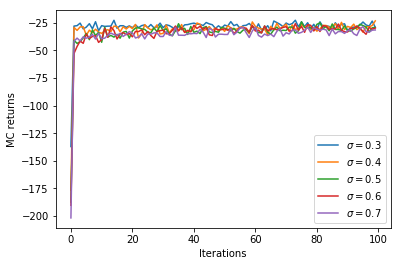

In [30]:
plt.figure()
for sigma in sigmas:
    plt.plot(MC_returns[sigma], label =r"$\sigma = {}$".format(sigma))
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

In [39]:
sigma = 0.7
learning_rate = 0.0001
N = 100
T = 400
# Number of policy parameters updates
n_itr = 100
discount = 0.9
# Learning rate for the gradient update
thetas = {}
MC_returns = {}
policy = GaussianPolicy(sigma, 0)
stepper = ConstantStep(learning_rate)
thetas , MC_returns, thetas_min, thetas_max  = REINFORCE(0, sigma, T, N, n_itr, stepper, discount)

No handles with labels found to put in legend.


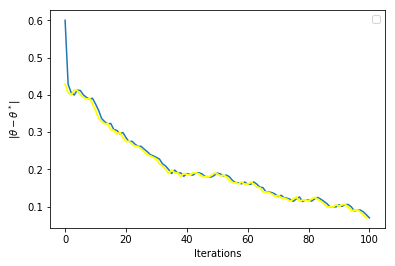

In [40]:
# theta*
theta_s = -0.6

plt.figure()
theta_diff = [abs(theta - theta_s) for theta in thetas]
theta_min_diff = [abs(theta - theta_s) for theta in thetas_min]
theta_max_diff = [abs(theta - theta_s) for theta in thetas_max]
plt.plot(theta_diff)
plt.plot(theta_min_diff, color="yellow")
plt.plot(theta_max_diff, color="yellow")
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

No handles with labels found to put in legend.


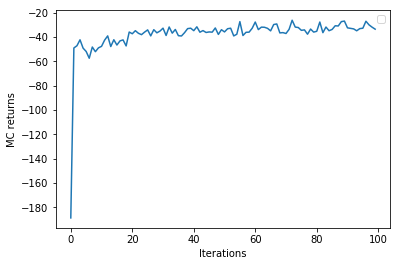

In [41]:
plt.figure()
plt.plot(MC_returns)
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

In [42]:
stepper = AdamStep(learning_rate)

thetas , MC_returns, thetas_min, thetas_max  = REINFORCE(0, sigma, T, N, n_itr, stepper, discount)

No handles with labels found to put in legend.


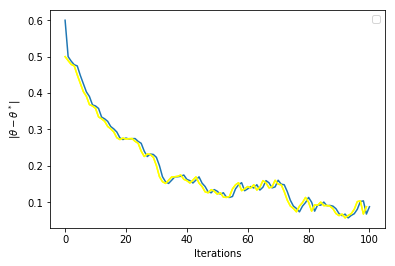

In [43]:
plt.figure()
theta_diff = [abs(theta - theta_s) for theta in thetas]
theta_min_diff = [abs(theta - theta_s) for theta in thetas_min]
theta_max_diff = [abs(theta - theta_s) for theta in thetas_max]
plt.plot(theta_diff)
plt.plot(theta_min_diff, color="yellow")
plt.plot(theta_max_diff, color="yellow")
plt.xlabel("Iterations")
plt.ylabel(r"$|\theta - \theta^*|$")
plt.legend()
plt.show()

No handles with labels found to put in legend.


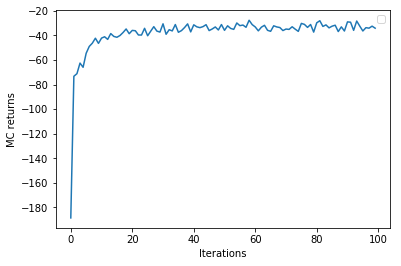

In [44]:
plt.figure()
plt.plot(MC_returns)
plt.xlabel("Iterations")
plt.ylabel("MC returns")
plt.legend()
plt.show()

## 2 - Off-Policy Reinforcement Learning with Value Function Approximation

In [45]:
class FQI:
    """
    Fitted Q-Iteration (FQI) algorithms is based on the fit of the empirical optimal Bellman operator in F 
    """
    def __init__(self, dataset, actions, policy , theta ,T, lmbd, gamma ):
        self.dataset = dataset
        self.policy = policy
        self.T = T 
        self.lmbd = lmbd
        self.gamma = gamma 
        self.actions = actions 
        self.theta = theta
        
    def phi(self, s, a):
        return np.array([a, s * a, s ** 2 + a ** 2])

    def Q(self, s, a):
        return self.phi(s, a).dot(self.theta)
    
    def run_fqi(self, n):
        """ Linear Fitted Q-iteration in iteration n"""
        Z = np.zeros((self.T, 3))
        Y = np.zeros(self.T)
        for t in range(self.T):
            state  = dataset[n]['states'][t]
            action = dataset[n]['actions'][t]
            reward = dataset[n]['rewards'][t]
            next_state = dataset[n]['next_states'][t]
            Z[t] = self.phi(state , action)
            Y[t] = reward + self.gamma * np.max([self.Q(next_state, a) for a in actions])

        self.theta = np.linalg.inv(np.transpose(Z).dot(Z) + self.lmbd * np.identity(3)).dot(np.transpose(Z)).dot(Y)
        return self.theta

    def draw_action(self, s):
        rewards = []
        for a in self.actions:
            rewards.append(self.Q(s, a))
        return self.actions[np.argmax(rewards)]

In [46]:
env = lqg1d.LQG1D(initial_state_type='random')
discount = 0.9
horizon = 50


actions = discrete_actions = np.linspace(-8, 8, 20)
theta = np.zeros((3,))


In [47]:
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T


Optimal K: [[-0.58840335]] Covariance S: 0.001


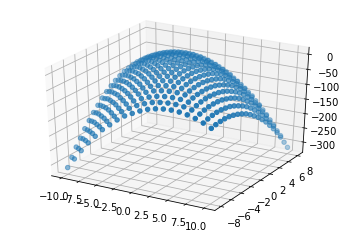

In [48]:
states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

plt.show()

In [49]:
class behavioral_policy(object):
    def __init__(self, a):
        self.actions = a

    def draw_action(self, s):
        return self.actions[np.random.randint(len(self.actions))]

In [50]:
b_policy = behavioral_policy(actions)
dataset = utils.collect_episodes(env, n_episodes=50 ,policy=b_policy, horizon=50)

In [51]:
fqi = FQI(dataset, actions, b_policy, theta, T=horizon , lmbd = 0.01 , gamma=discount )


In [52]:
# 1 iteration 
fqi.run_fqi(0)
J = utils.estimate_performance(env, policy=fqi, horizon=50, n_episodes=50, gamma=0.9)



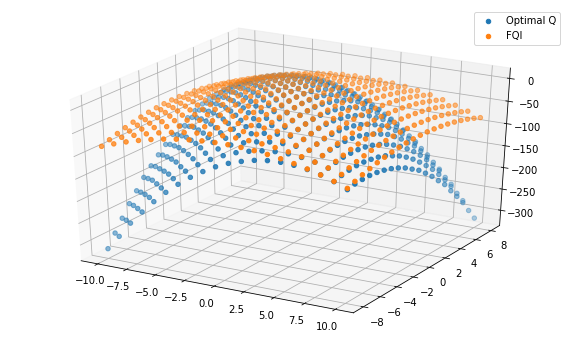

In [53]:
Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])
Q_opt = Q_fun(SA)

Q_fun2_ = np.vectorize(lambda s, a: fqi.Q(s, a))
Q_fun2 = lambda X: Q_fun2_(X[:, 0], X[:, 1])
Q_opt2 = Q_fun2(SA)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt, label = "Optimal Q")

ax.scatter(S, A, Q_opt2, label = "FQI")
plt.legend()
plt.show()

In [69]:
# 50 iterations 
fqi = FQI(dataset, actions, b_policy, theta, T=50, lmbd = 0.01 , gamma=discount )
J = []
for i in range(50):
    fqi.run_fqi(i)
    J.append(utils.estimate_performance(env, policy=fqi, horizon=50, n_episodes=50, gamma=0.9))

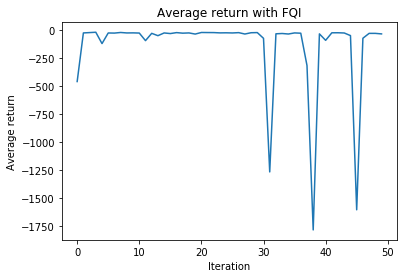

In [70]:
plt.figure()
plt.plot( J)
plt.title("Average return with FQI")
plt.xlabel("Iteration")
plt.ylabel("Average return")
plt.show()

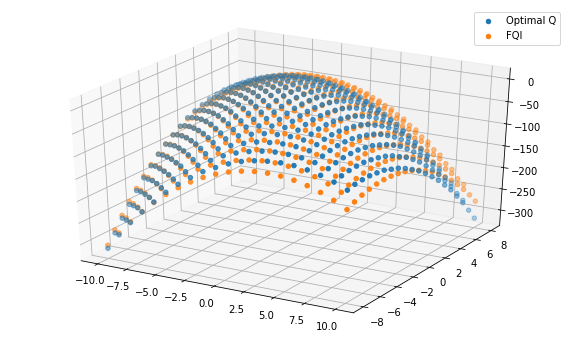

In [71]:
Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])
Q_opt = Q_fun(SA)

Q_fun2_ = np.vectorize(lambda s, a: fqi.Q(s, a))
Q_fun2 = lambda X: Q_fun2_(X[:, 0], X[:, 1])
Q_opt2 = Q_fun2(SA)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt, label = "Optimal Q")

ax.scatter(S, A, Q_opt2, label = "FQI")
plt.legend()
plt.show()

The algorithm seems not stable  and we have better results when we increase the iterations. 